# Splitter tutorial

This notebook presents the possibilities of splitters. They will help to split the train and test data.
RePlay offers several classes:

* TimeSplitter
* RandomSplitter
* NewUsersSplitter
* ColdUserRandomSplitter
* TwoStageSplitter

Each of them provides its own capabilities for data split.

### Split data

To split the data, you must call the `.split()` method on the Splitter object

### Return

Splitters return `train` and `test` cached DataFrame to compute them once and re-use for models training, inference and metrics calculation.


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from replay.preprocessing.data_preparator import DataPreparator, Indexer
from replay.utils import convert2spark, get_log_info

sns.set_theme(style="whitegrid", palette="muted")

## Get started

Download the dataset **MovieLens** and preprocess it with `DataPreparator` and `Indexer`

In [3]:
ratings = pd.read_csv('./data/ml1m_ratings.dat',sep="\t",names=["userId", "itemId", "relevance", "timestamp"],engine='python')

In [4]:
ratings.head(5)

,userId,itemId,relevance,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
dp = DataPreparator()
log = dp.transform(data=ratings,
                  columns_mapping={
                      "user_id": "userId",
                      "item_id":  "itemId",
                      "relevance": "relevance",
                      "timestamp": "timestamp"
                  })

log.show(2)

20-Sep-22 13:28:50, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


+-------+-------+---------+-------------------+
|user_id|item_id|relevance|          timestamp|
+-------+-------+---------+-------------------+
|      1|   1193|      5.0|2001-01-01 01:12:40|
|      1|    661|      3.0|2001-01-01 01:35:09|
+-------+-------+---------+-------------------+
only showing top 2 rows



In [9]:
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=log.select('user_id'),
            items=log.select('item_id'))
log = indexer.transform(df=log)
log.show(2)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|    4131|      43|      5.0|2001-01-01 01:12:40|
|    4131|     585|      3.0|2001-01-01 01:35:09|
+--------+--------+---------+-------------------+
only showing top 2 rows



For examples, we will use the first 20 users

In [10]:
log_limit_20 = log.filter("user_idx < 20")

Function for viewing `train`, `test` data

In [11]:
def show_train_test(train, test):
    plt.figure(figsize=(25,12))
    train_plt = train.toPandas()
    train_plt["split"] = 'train'
    test_plt = test.toPandas()
    test_plt["split"] = 'test'
    pd_for_print = pd.concat((train_plt, test_plt), axis=0)
    pd_for_print["user_idx"] = pd_for_print["user_idx"].astype(str)
    sns.scatterplot(data=pd_for_print, x="timestamp", y="user_idx", hue="split",s=8*8)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()

## General parameters of splitters

All splitters has the following common parameters:
* `drop_cold_users` flag to drop cold (not presented in train part) users from test

* `drop_cold_items` flag to drop cold (not presented in train part) users from test

* `date_column` timestamp column name

* `query_column` query id column name

* `item_column` item id column name

## class TimeSplitter()

Split into train and test by date.

#### Parameters other than gneral

* `test_start` string "yyyy-mm-dd" , int unix timestamp, datetime or a fraction for test size to determine the date automatically


In this example `test_start` parameter will take fraction for test size

In [12]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    test_start=0.05,
    drop_cold_users=True,
    drop_cold_items=True,
    drop_zero_rel_in_test=True
)

In [13]:
train, test = date_splitter.split(log_limit_20)

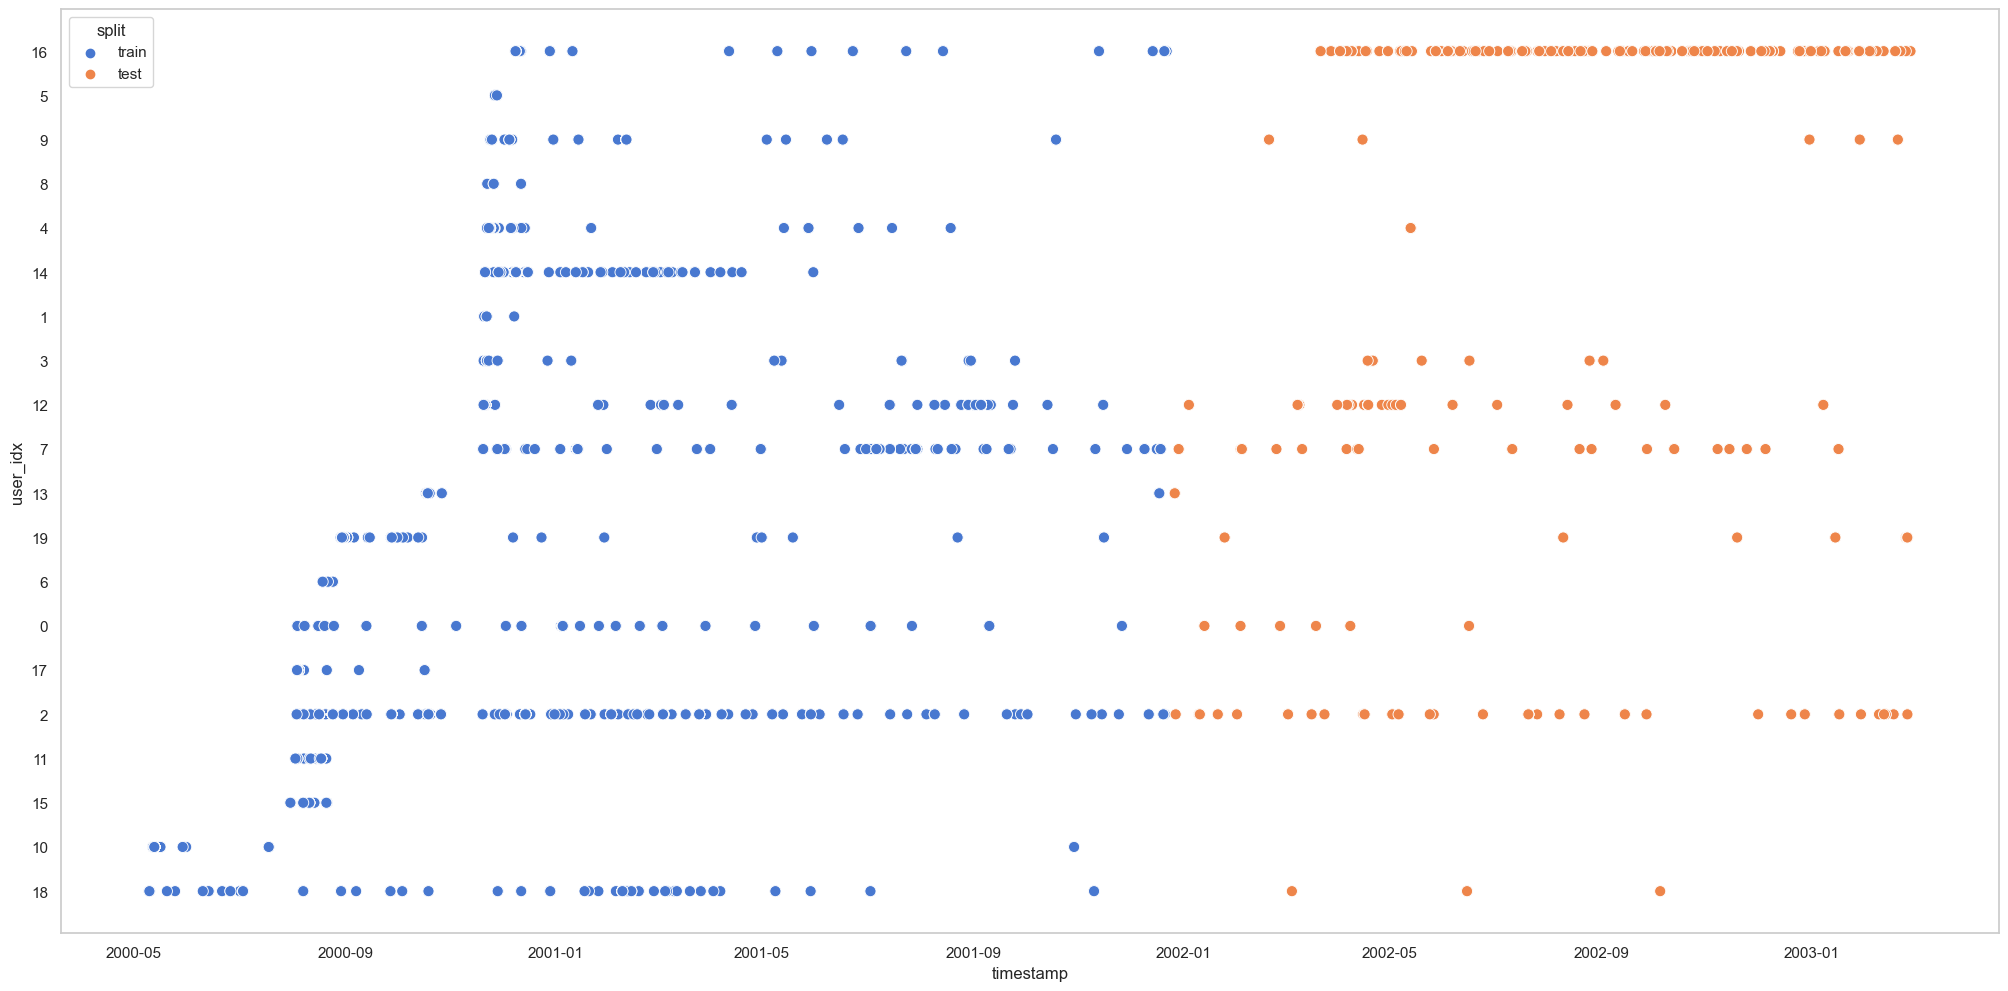

In [14]:
show_train_test(train, test)

In [15]:
get_log_info(train)

'total lines: 26816, total users: 20, total items: 3303'

In [16]:
get_log_info(test)

'total lines: 1387, total users: 11, total items: 1152'

In this example `test_start` parameter will take string "yyyy-mm-dd"

In [17]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    test_start="2001-09",
    drop_cold_users=True,
    drop_cold_items=True,
    drop_zero_rel_in_test=True,
    time_column_format="%Y-%m"
)

In [18]:
train, test = date_splitter.split(log_limit_20)

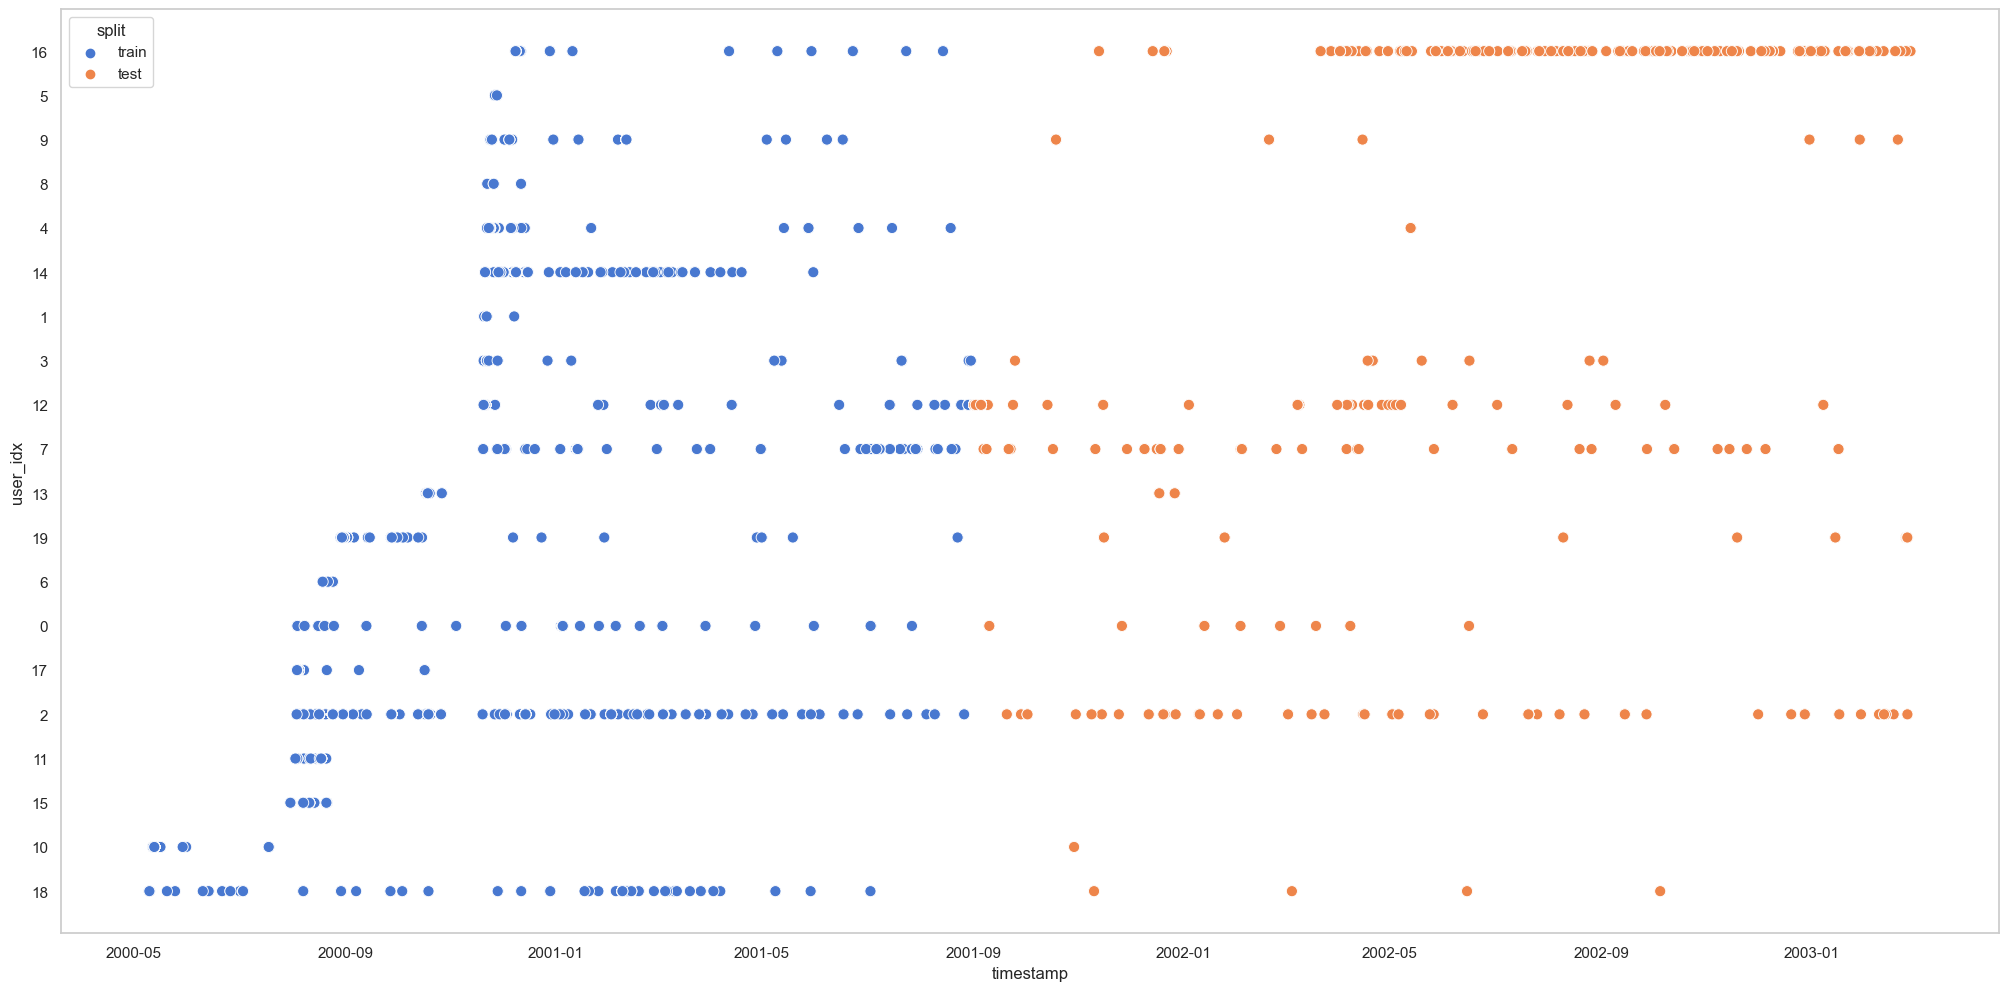

In [19]:
show_train_test(train, test)

In [20]:
get_log_info(train)

'total lines: 26345, total users: 20, total items: 3281'

In [21]:
get_log_info(test)

'total lines: 1834, total users: 12, total items: 1399'

### Learn more about the parameters `drop_cold_users`, `drop_cold_items`, `drop_zero_rel_in_test`

#### All parameters is false

In [22]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    test_start=0.3,
    drop_cold_users=False,
    drop_cold_items=False,
    drop_zero_rel_in_test=False
)

Let's look at the result of filtering using the function  `get_log_info()`

In [24]:
train, test = date_splitter.split(log)
get_log_info(test)

'total lines: 300065, total users: 2283, total items: 3572'

#### `drop_cold_users` is True 

In [25]:
date_splitter = TimeSplitter(
    test_start=[0.3],
    drop_cold_users=True,
    drop_cold_items=False,
    drop_zero_rel_in_test=False
)

Let's look at the result of filtering using the function  `get_log_info()` with `drop_cold_users=True`. Compared to the disabled flag, the number of users has decreased.

In [26]:
train, test = date_splitter.split(log)
get_log_info(test)

'total lines: 111169, total users: 1113, total items: 3459'

#### `drop_cold_items` is True 

In [27]:
date_splitter = TimeSplitter(
    test_start=[0.3],
    drop_cold_users=False,
    drop_cold_items=True,
    drop_zero_rel_in_test=False
)

Let's look at the result of filtering using the function  `get_log_info()` with `drop_cold_items=True`. Compared to the disabled flag, the number of items has decreased.

In [29]:
train, test = date_splitter.split(log)
get_log_info(test)

'total lines: 299894, total users: 2283, total items: 3499'

#### `drop_zero_rel_in_test` is True 

In [30]:
date_splitter = TimeSplitter(
    test_start=[0.3],
    drop_cold_users=False,
    drop_cold_items=False,
    drop_zero_rel_in_test=True
)

Let's look at the result of filtering using the function  `get_log_info()` with `drop_zero_rel_in_test=True`. 
In the dataset chosen for the test, the scores are from 1 to 5, so the total number of records has not changed.

In [32]:
train, test = date_splitter.split(log)
get_log_info(test)

'total lines: 300065, total users: 2283, total items: 3572'

## class RandomSplitter()

Assign records into train and test at random.

#### Parameters other than general

* `test_size` float 

* `seed` random seed

In [33]:
from replay.splitters.log_splitter import RandomSplitter

random_splitter = RandomSplitter(
    test_size=0.4,
    drop_cold_users=True,
    drop_cold_items=True,
    drop_zero_rel_in_test=True
)

In [34]:
train, test = random_splitter.split(log_limit_20)

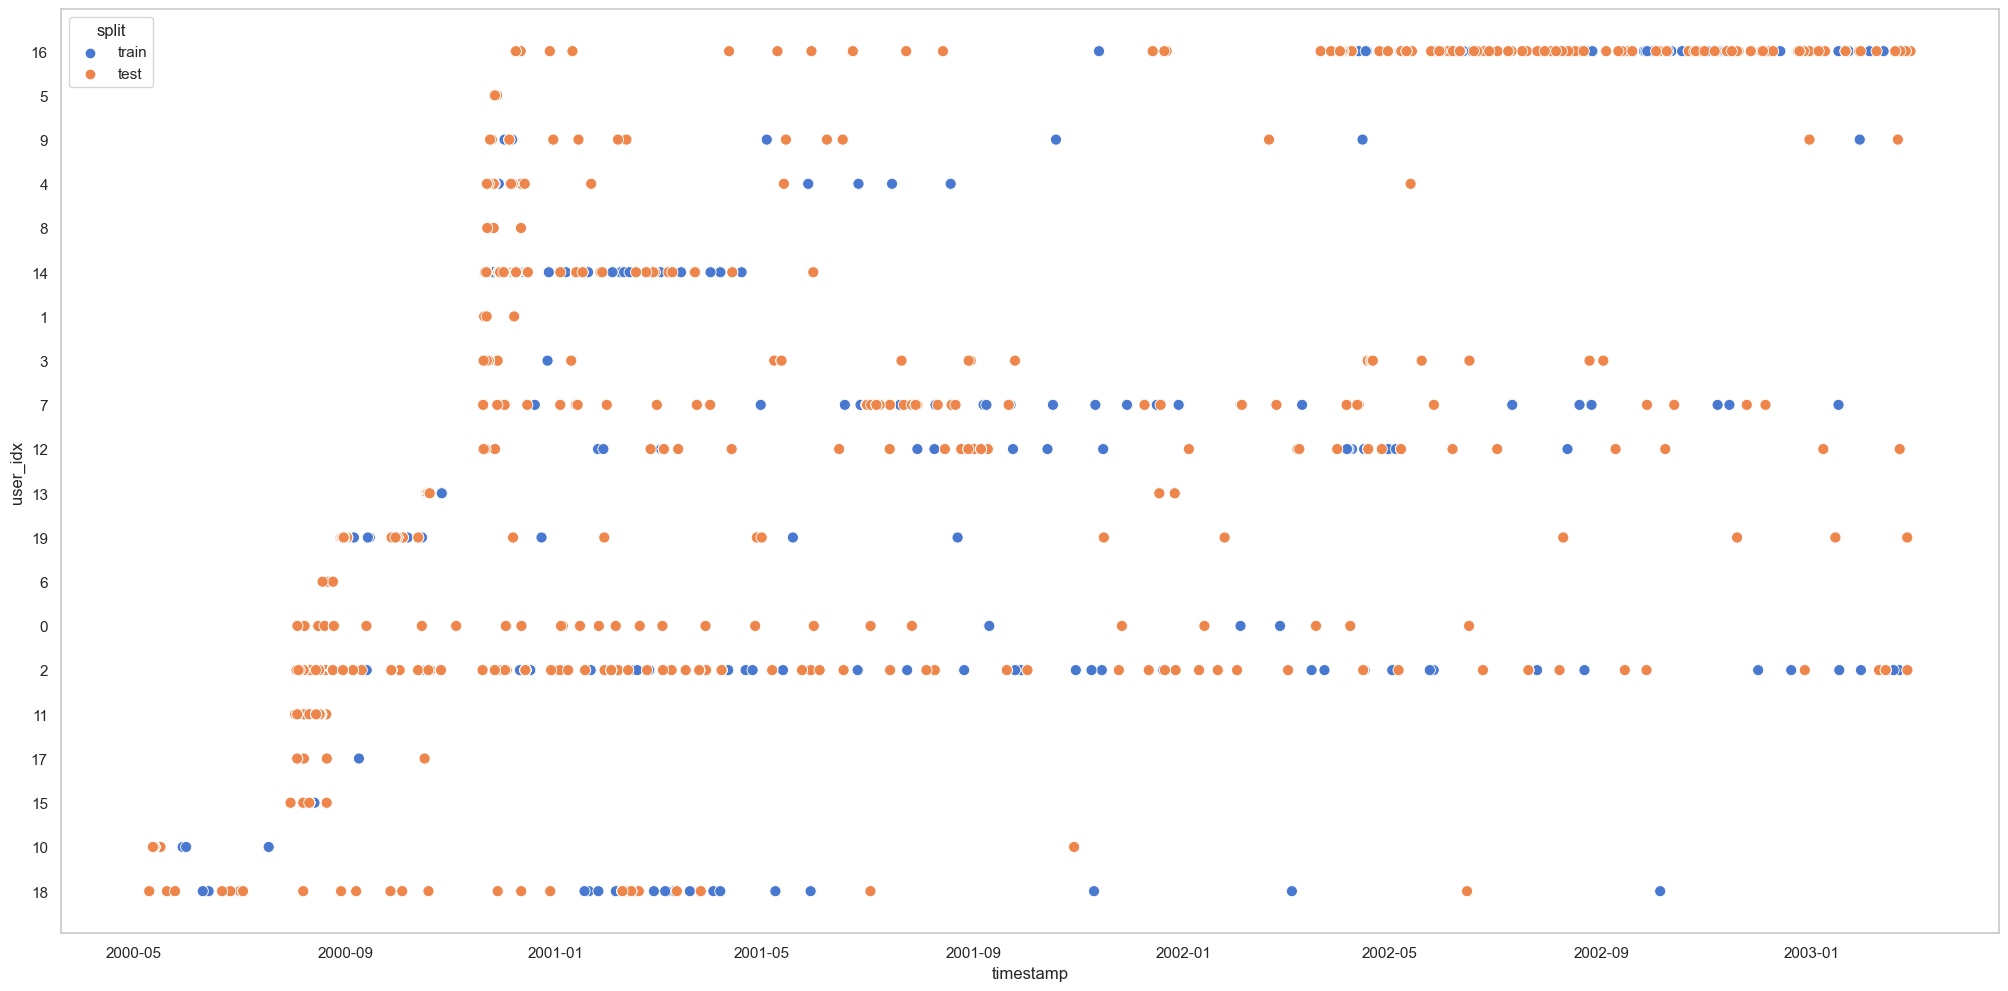

In [35]:
show_train_test(train, test)

In [36]:
get_log_info(train)

'total lines: 16817, total users: 20, total items: 3139'

In [37]:
get_log_info(test)

'total lines: 11113, total users: 20, total items: 2760'

## class NewUsersSplitter()

Only new users will be assigned to test set.
Splits log by timestamp so that test has `test_size` fraction of most recent users.

#### Parameters other than general

* `test_size` float 

In [38]:
from replay.splitters.log_splitter import NewUsersSplitter

new_user_splitter = NewUsersSplitter(
    test_size=0.3
)

In [39]:
train, test = new_user_splitter.split(log_limit_20)

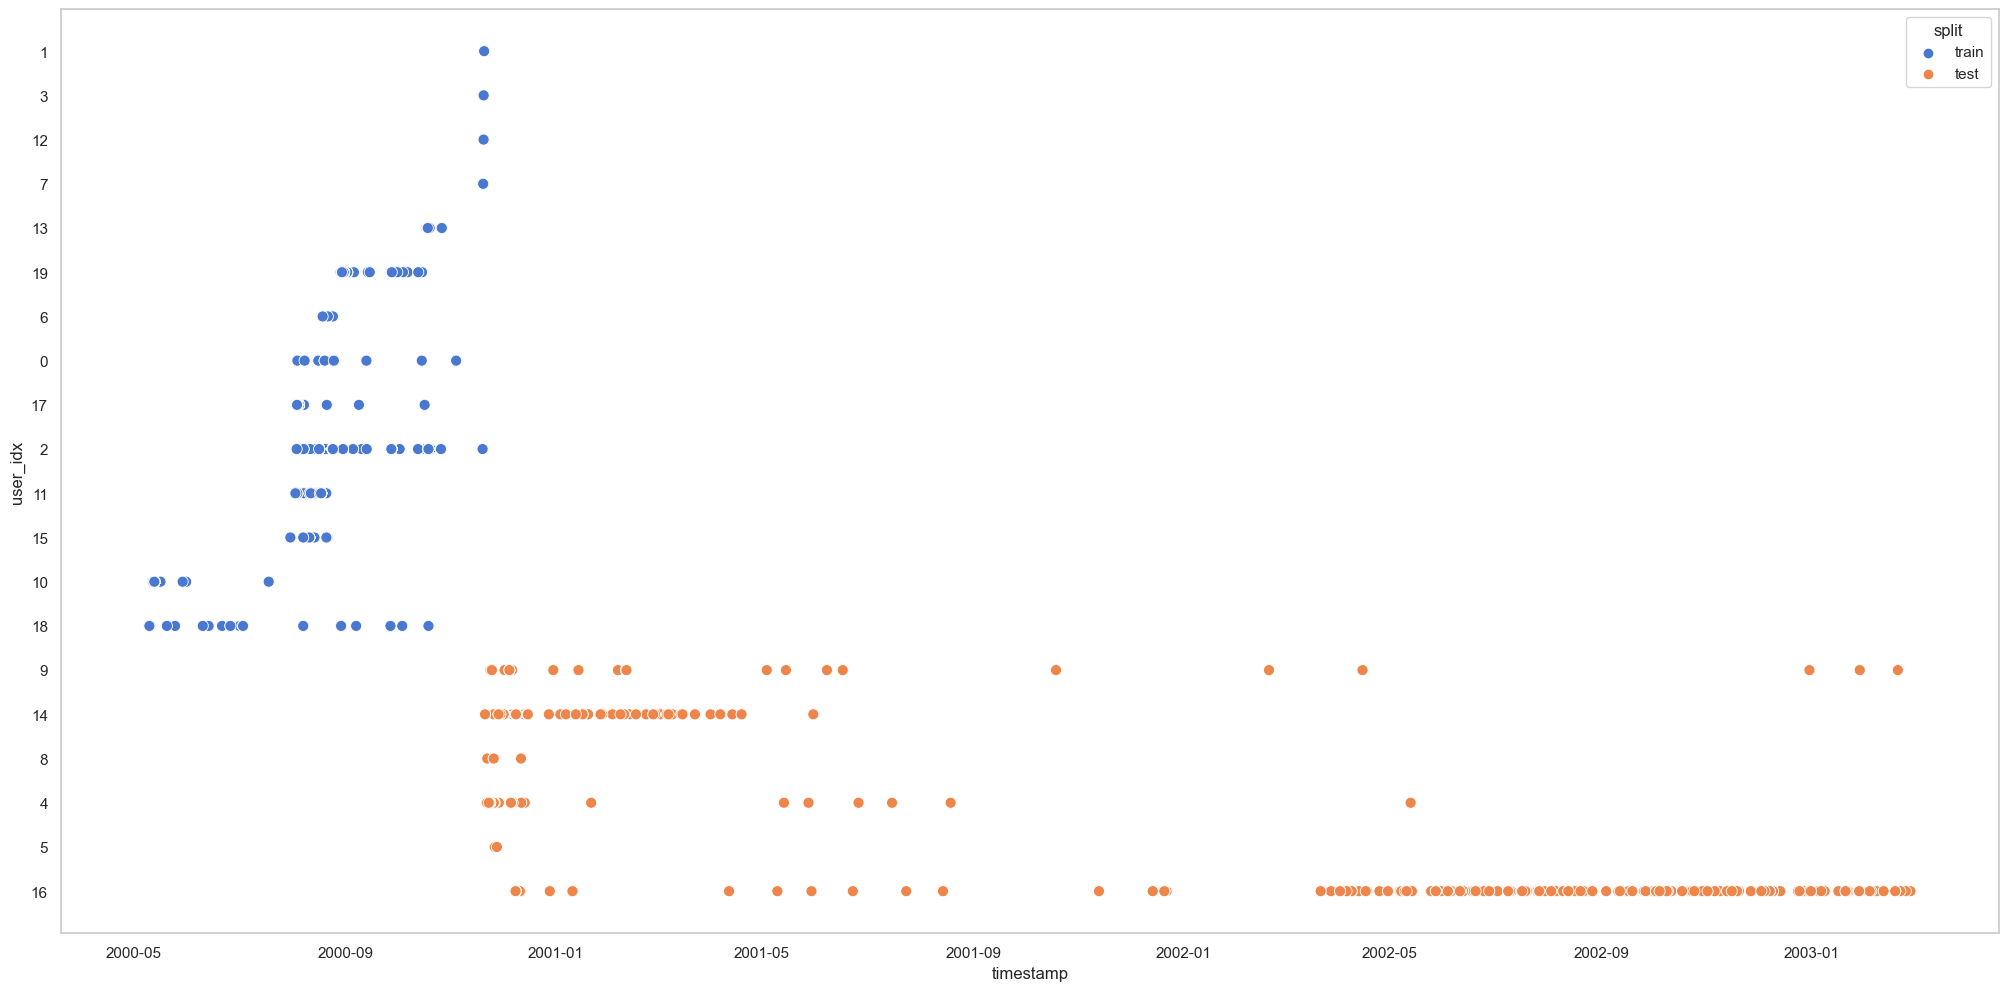

In [40]:
show_train_test(train, test)

In [41]:
get_log_info(train)

'total lines: 13952, total users: 14, total items: 2931'

In [42]:
get_log_info(test)

'total lines: 8096, total users: 6, total items: 2757'

## class ColdUserRandomSplitter()

Test set consists of all actions of randomly chosen users.

#### Parameters other than general

* `test_size` float 

* `seed` random seed

In [43]:
from replay.splitters.log_splitter import ColdUserRandomSplitter

cold_user_random_splitter = ColdUserRandomSplitter(
    test_size=0.3
)

In [44]:
train, test = cold_user_random_splitter.split(log_limit_20)

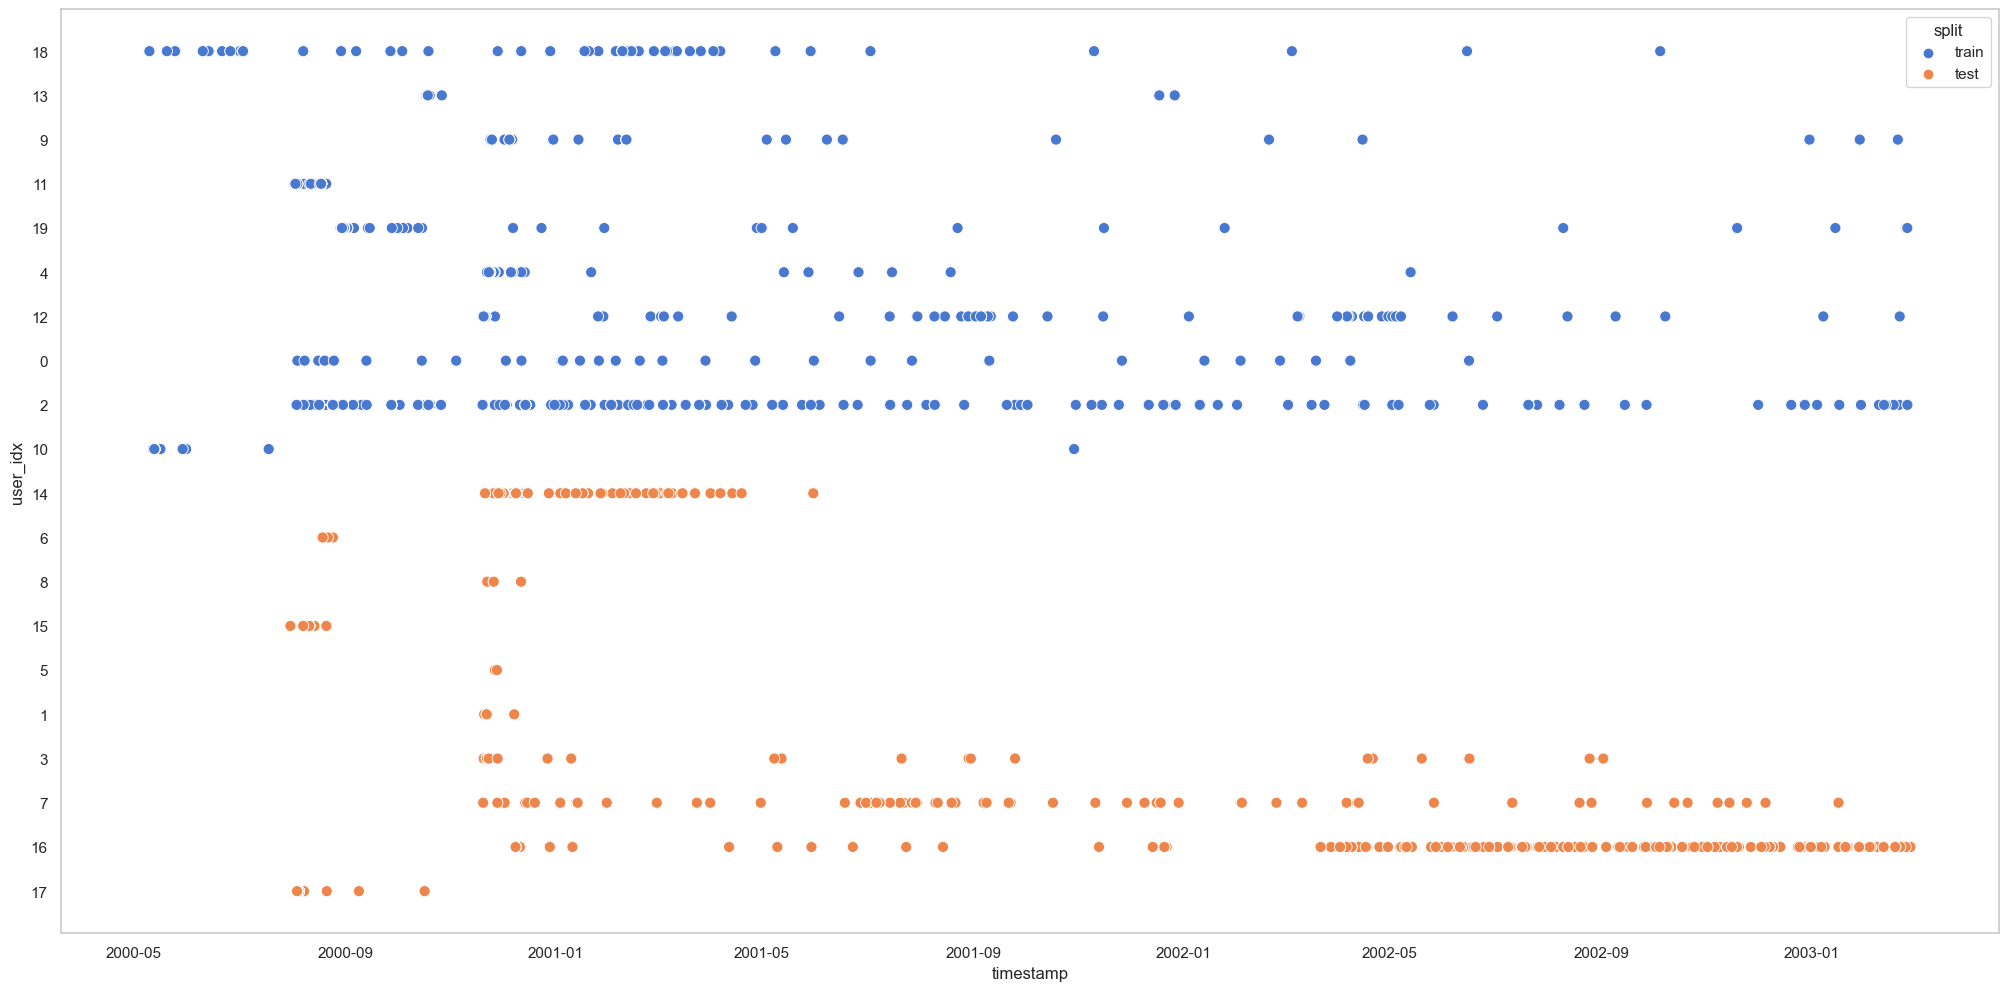

In [45]:
show_train_test(train, test)

In [46]:
get_log_info(train)

'total lines: 14366, total users: 10, total items: 3120'

In [47]:
get_log_info(test)

'total lines: 13863, total users: 10, total items: 3081'

## class TwoStageSplitter()

Split data by two columns.

#### Parameters other than general

* `item_test_size` Number of items to be added to the test for each user

* `user_test_size` Number of users to be added to the test

* `seed` random seed

In this example 10 users are randomly selected, 50 products are included in the test for each user. `shuffle` parameter is False. Separation in each selected user occurs on a timeline

In [48]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=10,
    second_divide_size=50,
    shuffle=False
)

In [55]:
train, test = user_splitter.split(log_limit_20)

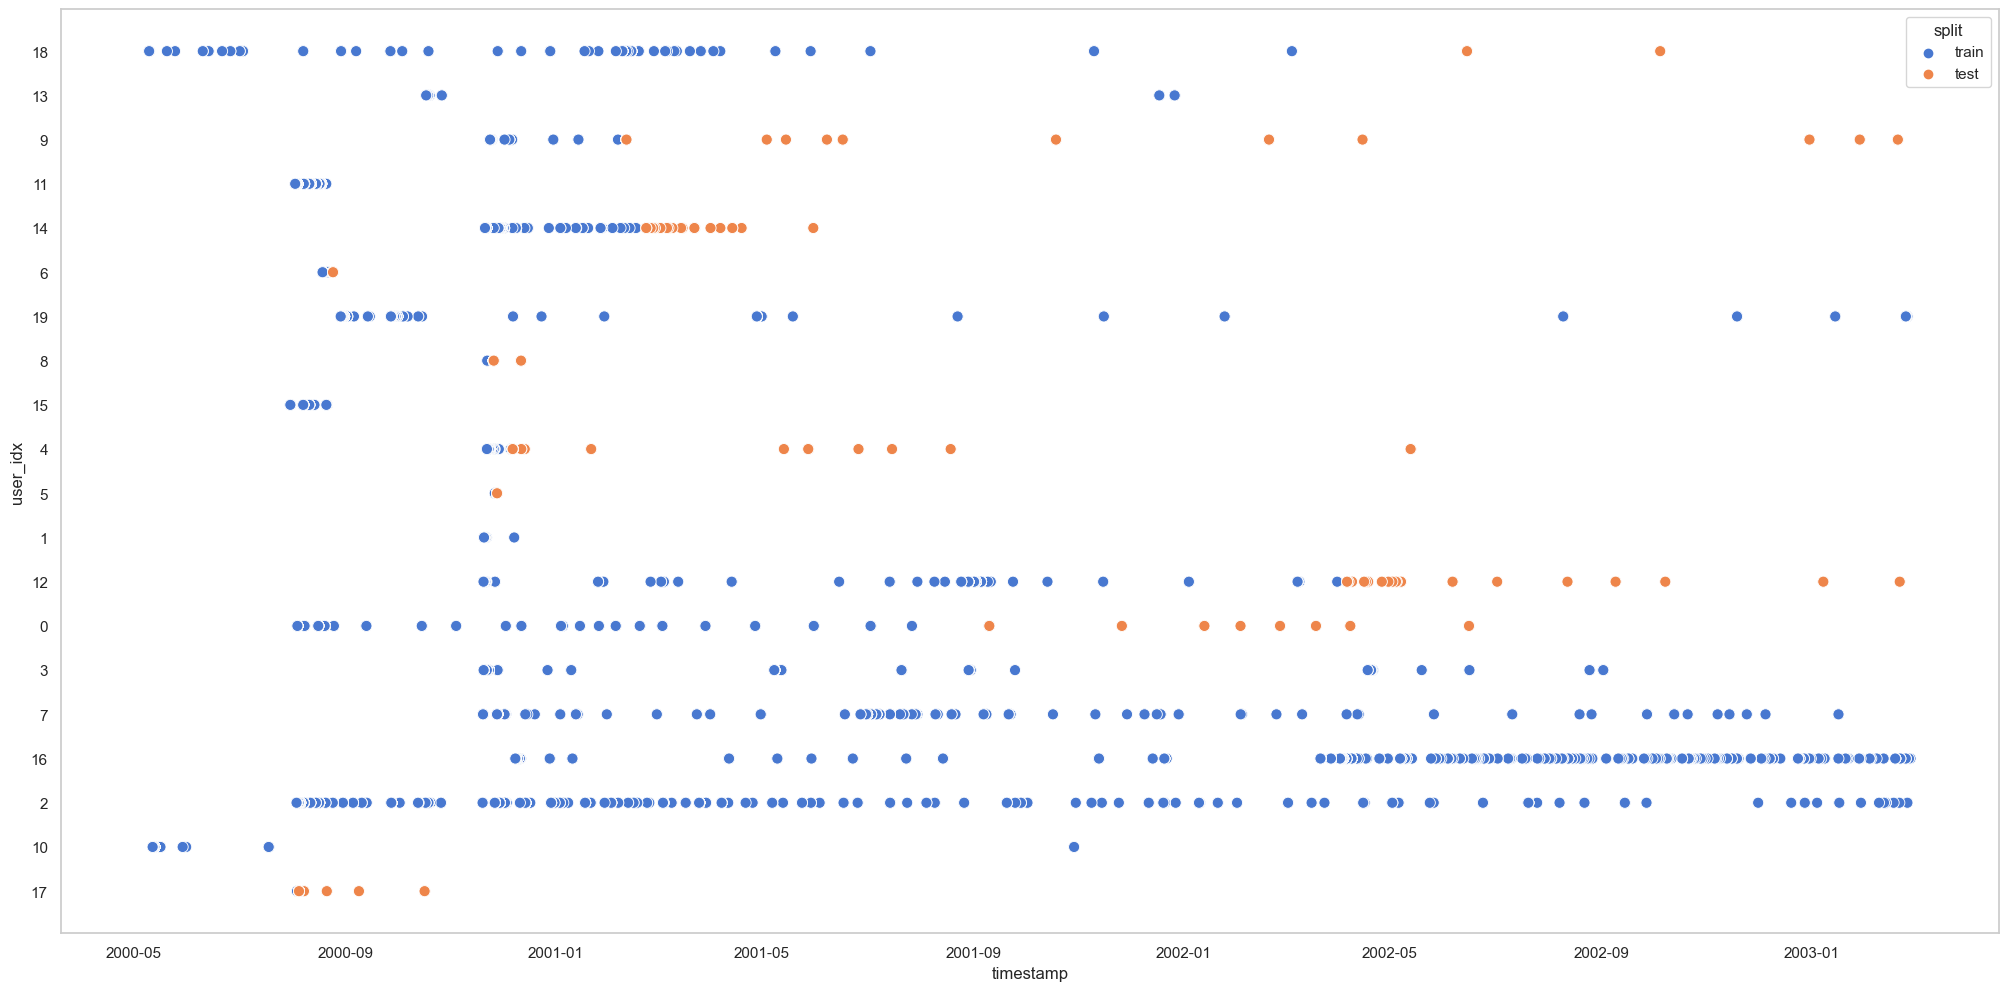

In [56]:
show_train_test(train, test)

In [57]:
get_log_info(train)

'total lines: 27729, total users: 20, total items: 3300'

In [58]:
get_log_info(test)

'total lines: 500, total users: 10, total items: 458'

In this example 10 users are randomly selected, 50 products are included in the test for each user. In this example `shuffle` parameter is True. Split in each selected user occurs random

In [59]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=10,
    second_divide_size=50,
    shuffle=True
)

In [60]:
train, test = user_splitter.split(log_limit_20)

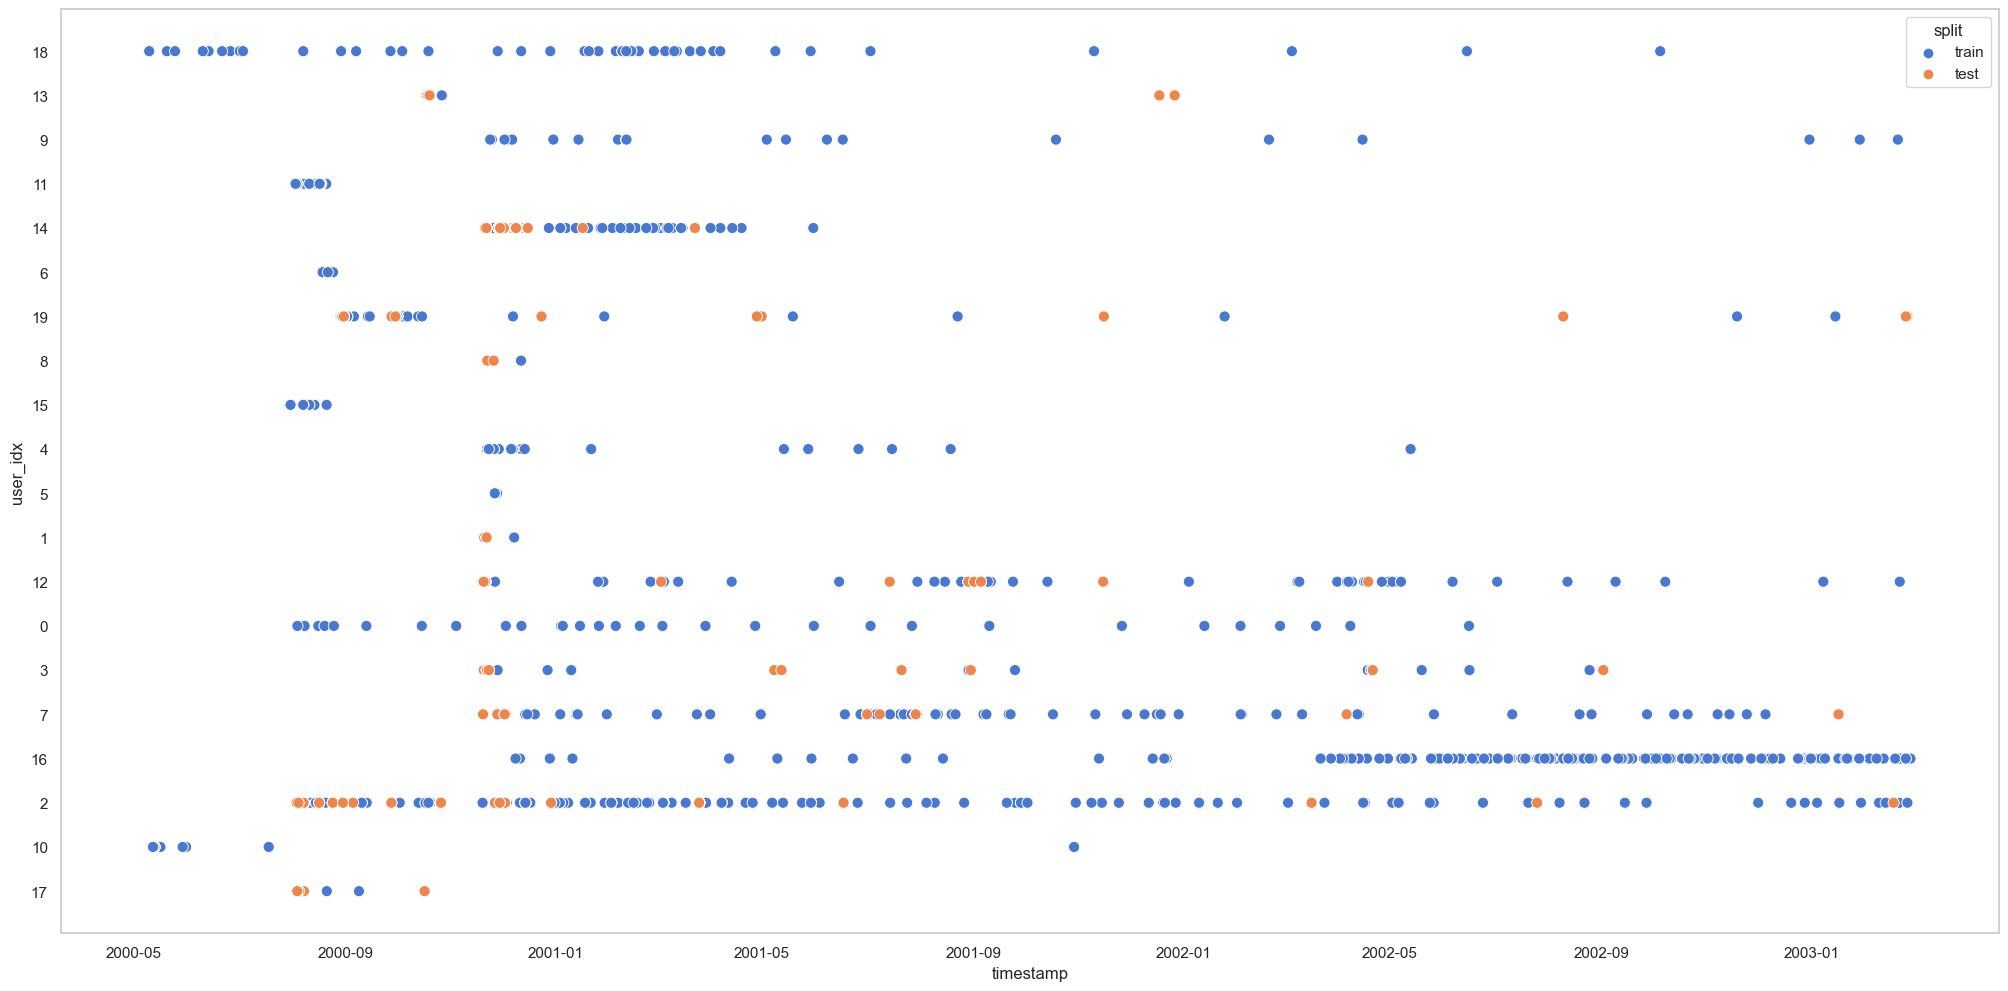

In [62]:
show_train_test(train, test)

In [63]:
get_log_info(train)

'total lines: 27729, total users: 20, total items: 3323'

In [64]:
get_log_info(test)

'total lines: 500, total users: 10, total items: 456'

You can use **float** as input for `item_test_size` or `user_test_size` parameters

In [65]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=0.5,
    second_divide_size=0.015,
    shuffle=True
)

In [66]:
train, test = user_splitter.split(log_limit_20)

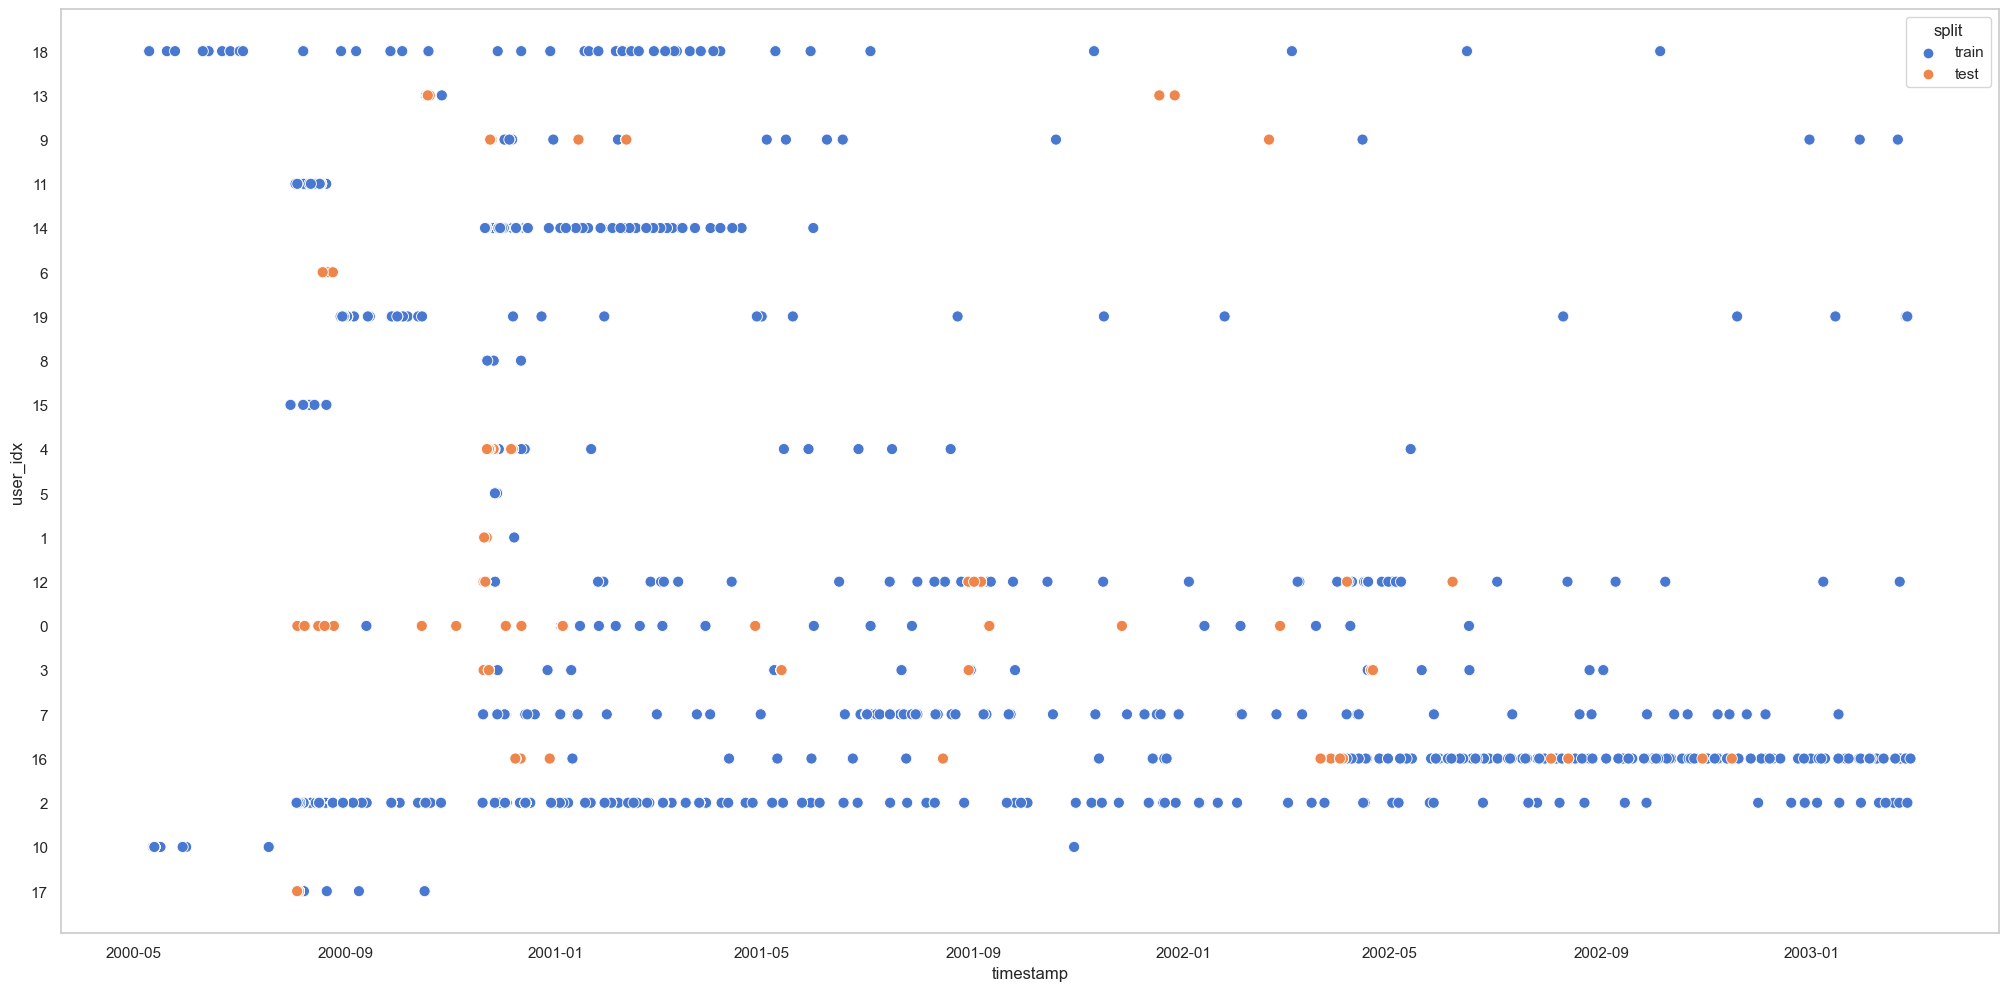

In [67]:
show_train_test(train, test)

In [68]:
get_log_info(train)

'total lines: 28012, total users: 20, total items: 3321'

In [69]:
get_log_info(test)

'total lines: 217, total users: 10, total items: 209'